# Scraping

In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import requests
import time
import datetime as dt 
import pandas as pd

import os
import pickle

pd.options.display.max_columns=200


headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Disable images

driver = webdriver.Edge(options=edge_options)
driver.maximize_window()

In [2]:
url="https://www.chrono24.com/search/browse.htm"
driver.get(url)
time.sleep(5)

In [3]:
try:
    driver.find_element(By.CSS_SELECTOR,'div[class="js-modal-content modal-content"] button[type="button"]').click()
except:
    None

In [ ]:
brand_url_dict={}
for e in driver.find_elements(By.CSS_SELECTOR,'section[class="m-b-7"] ul[class="list-unstyled row"] li'):
    brand=e.text
    url=e.find_element(By.CSS_SELECTOR,'a').get_attribute('href')

    brand_url_dict[brand]=url

In [ ]:
all_urls=[]

for i,(brand, brand_url) in enumerate(brand_url_dict.items(),start=1):

    driver.get(brand_url)
    time.sleep(2)

    try:
        driver.find_element(By.CSS_SELECTOR,'div[class="js-modal-content modal-content"] button[type="button"]').click()
    except:
        None

    page=1
    while True:
        url_elements=driver.find_elements(By.CSS_SELECTOR,'div[class="js-article-item-container article-item-container wt-search-result article-image-carousel"] a')
        for url_element in url_elements:
            try:
                watch_url=url_element.get_attribute('href')
                all_urls.append(watch_url)
            except:
                continue

        try:
            next_page_button=driver.find_element(By.CSS_SELECTOR,'div[class="js-next-item-container next-item-container border border-radius-large"] a')
            driver.execute_script('arguments[0].click();',next_page_button)
        except:
            break

        page+=1
        if page==6:
            break

        print(f'Progress: {i}/{len(brand_url_dict)}, Page: {page}',end='\r')


pickle.dump(all_urls,open('all_urls.pickle','wb'))

In [3]:
all_urls=pickle.load(open('all_urls.pickle','rb'))
all_urls=list(set(all_urls))
all_urls=sorted(all_urls)
len(all_urls)

52888

In [4]:
def return_info_dict(watch_url):
    try:
        driver.get(watch_url)
        html=driver.page_source
        soup=BeautifulSoup(html)
    except:
        pass

    info_dict = {}
    info_dict['Watch URL']=watch_url

    # Extract info lines
    info_lines = soup.select('div[class="col-xs-24 col-md-12"] tr')
    for info_line in info_lines:
        try:
            label = info_line.select('td')[0].text.strip().replace('\n','')
            value = info_line.select('td')[1].text.strip().replace('\n','')
            info_dict[label] = value
        except:
            continue

    # Extract seller sales information
    try:
        seller_sales = soup.select_one('section[id="js-seller"] div[class="d-flex border border-radius-large m-b-lg-0 m-b-md-4 m-b-sm-4"]').text.replace('\n','').strip()
        info_dict['Seller Sales'] = seller_sales
    except:
        info_dict['Seller Sales'] = None

    # Extract seller badges
    try:
        seller_badges = '|'.join([i.text.replace('\n','').strip() for i in soup.select('section[id="js-seller"] div[class="same-height p-x-3"] div strong')])
        info_dict['Seller Badges'] = seller_badges
    except:
        info_dict['Seller Badges'] = None

    # Extract seller ratings
    try:
        seller_ratings = '|'.join([i.text.replace('\n','').strip() for i in soup.select('div[class="col-xs-24"] div[class="m-b-2"], div[class="m-t-3 m-t-sm-5"]')])
        info_dict['Seller Ratings'] = seller_ratings
    except:
        info_dict['Seller Ratings'] = None

    return info_dict


In [ ]:
max_index=0
for file in os.listdir(os.path.join('data_files')):
    if file.endswith('csv')==False:
        index=int(file.split('_')[-1])
        if index>max_index:
            max_index=index

print(f'Scraped {max_index}')

In [ ]:
info_dicts=[]

for i, watch_url in enumerate(all_urls,start=1):
    if i<=max_index:
        continue
    info_dict=return_info_dict(watch_url)
    info_dicts.append(info_dict)
    time.sleep(0.5)

    if i%1000==0 or i==len(all_urls):
        pickle.dump(info_dicts, open(os.path.join('data_files',f'info_dicts_new{i}'),'wb'))
        info_dicts=[]

    print(f'Progress : {i}/{len(all_urls)}',end='\r')


# Preprocessing

In [5]:
import pandas as pd
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [6]:
all_data=[]
for file in os.listdir(os.path.join('data_files')):
    if file.endswith('.csv')==False:
        file_path=os.path.join('data_files',file)
        data=pickle.load(open(file_path,'rb'))
        all_data.extend(data)

In [7]:
df=pd.DataFrame(all_data)

In [8]:
df=df.drop_duplicates(subset='Watch URL')

In [9]:
df.sample(5)

,Watch URL,Listing code,Brand,Reference number,Movement,Case material,Bracelet material,Year of production,Condition,Scope of delivery,Gender,Location,Price,Availability,Caliber/movement,Base caliber,Case diameter,Water resistance,Bezel material,Crystal,Dial,Dial numerals,Bracelet color,Clasp,Clasp material,Seller Sales,Seller Badges,Seller Ratings,Model,Power reserve,Number of jewels,Dealer product code,Thickness,Most Recent Servicing,Lug width,Frequency,Bracelet length,Buckle width,Bracelet thickness
5473,https://www.chrono24.com/meistersinger/perigra...,KBZDB4,Meistersinger,AM1003,Automatic,NaN,NaN,Unknown,New The item is new and...,"Original box, original papers",Men's watch/Unisex,"United States of America, Florida, Naples","$2,499",Item is in stock,NaN,NaN,43 x 38 mmTry it on,5 ATM,NaN,Sapphire crystal,Champagne,NaN,NaN,Buckle,NaN,957watches sold 509active ...,Punctuality|Response Time|Sales,Reviews (808)|4.7 Shipp...,Perigraph,NaN,NaN,AM1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61766,https://www.chrono24.com/porschedesign/rs-spyd...,KNKAE2,Porsche Design,WAP07000818,Quartz,Steel,Rubber,2008,Used (Very good) The it...,"Original box, original papers",Men's watch/Unisex,"The Netherlands, Rijswijk",€599 (= $645) [Negotiable],Item is in stock,quartz,NaN,42 mmTry it on,120 ATM,NaN,Sapphire crystal,NaN,NaN,Black,Fold clasp,Steel,None,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55646,https://www.chrono24.com/breitling/superocean-...,MCGBT0,Breitling,a73310a8bb73,Quartz,Steel,Steel,2014,Used (Very good) The it...,"Original box, original papers",Men's watch/Unisex,"United States of America, New York","$3,899 [Negotiable]",Item is in stock,NaN,NaN,46 mmTry it on,Over 120 ATM,Steel,Sapphire crystal,Black,No numerals,Steel,Fold clasp,Steel,449watches sold 89active l...,Trusted Seller|Fast Shipper|Punctuality|Respon...,Reviews (324)|5.0 Shipp...,Superocean Chronograph M2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8293,https://www.chrono24.com/ebel/ebel-1911-discov...,K9XU95,Ebel,E 9750 L 62,Automatic,Steel,Steel,2008 (Approximation),Used (Good) The item sh...,"Original papers, no original box",Men's watch/Unisex,"The Netherlands, Den Haag","€1,600 (= $1,735)",Item is in stock,E750,NaN,43 mmTry it on,10 ATM,Steel,Sapphire crystal,Silver,No numerals,Steel,Fold clasp,Steel,680watches sold 157active ...,Trusted Seller|Fast Shipper|Punctuality|Respon...,Reviews (488)|5.0 Shipp...,1911 Discovery,NaN,NaN,O2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56016,https://www.chrono24.com/bulova/jet-star--id37...,M85AL1,Bulova,97b214,Quartz,Steel,Leather,2024 (Approximation),Like new & unworn The i...,"Original box, original papers",Men's watch/Unisex,"United States of America, Alabama, Richmond",$469 [Negotiable],Item is in stock,NaN,NaN,40 mmTry it on,NaN,NaN,NaN,Gold,NaN,Brown,NaN,NaN,None,,,Jet Star,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(45024, 39)

In [11]:
df.to_csv(os.path.join('data_files','watches.csv'),index=False)

In [12]:
df=df[list(df.isna().mean()[df.isna().mean()<0.5].index)]

In [13]:
df.nunique()[df.nunique()>50]

Watch URL             45024
Listing code          43730
Brand                   479
Reference number      28177
Year of production      262
Location               5808
Price                 18107
Case diameter          3122
Seller Sales           5140
Seller Ratings         2457
dtype: int64

In [14]:
df=df.drop(columns=['Watch URL','Listing code','Reference number','Location'])

In [15]:
df.nunique()

Brand                   479
Movement                  5
Case material            20
Bracelet material        26
Year of production      262
Condition                 7
Scope of delivery         4
Gender                    2
Price                 18107
Availability              3
Case diameter          3122
Water resistance         25
Crystal                   5
Dial                     22
Bracelet color           18
Clasp                     6
Seller Sales           5140
Seller Badges             5
Seller Ratings         2457
dtype: int64

In [16]:
df['Year of production']=df['Year of production'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).replace('Unknown',None).apply(pd.to_numeric,errors='coerce')

In [17]:
df['Condition']=df['Condition'].apply(lambda x:x.split('   ')[0] if isinstance(x,str) else None)

In [18]:
df['Price']=df['Price'].apply(lambda x:x.split('$')[-1].split(' ')[0] if isinstance(x,str) else None).str.replace(')','').str.replace(',','').apply(pd.to_numeric,errors='coerce')

In [19]:
df['Case diameter']=df['Case diameter'].apply(lambda x:x.split('mm')[0].split('MM')[0].strip() if isinstance(x,str) else None)
df['Case diameter']=df['Case diameter'].str.replace(',','.')

shape=df['Case diameter'].apply(lambda x: 
                          'Circular' if isinstance(x,str) and 'x' not in x else 
                          'Rectangular'if isinstance(x,str) and 'x' in x else None)


def return_value(x):
    try:
        if isinstance(x, str):
            if 'x' not in x:
                return ((float(x) / 2) ** 2) * 3.14 / 2  # Circular area approximation
            else:
                return float(x.split('x')[0]) * float(x.split('x')[1])  # Rectangular area
        return None
    except:
        return None

face_area=df['Case diameter'].apply(lambda x:return_value(x))

df.insert(df.columns.get_loc('Case diameter')+1,'Shape',shape)
df.insert(df.columns.get_loc('Case diameter')+2,'Face Area',face_area)

df=df.drop(columns='Case diameter')

In [20]:
df['Water resistance']=df['Water resistance'].replace('Not water resistant',0)
df['Water resistance']=df['Water resistance'].apply(lambda x:''.join([i for i in x if i.isdigit()]) if isinstance(x,str) else None).apply(pd.to_numeric)

In [21]:
df['Watches Sold by the Seller']=df['Seller Sales'].apply(lambda x:x.split('watches sold')[0].replace(',','') if isinstance(x,str) else None).apply(pd.to_numeric)
df['Active listing of the seller']=df['Seller Sales'].apply(lambda x:x.split('watches sold')[-1].split('active list')[0].replace(',','') if isinstance(x,str) else None).apply(pd.to_numeric)

df=df.drop(columns='Seller Sales')

In [22]:
badges=['Fast Shipper','Trusted Seller','Punctuality']

for badge in badges:
    df[badge] = df['Seller Badges'].apply(lambda x: 1 if badge in x else 0)

df=df.drop(columns='Seller Badges')

In [23]:
df['Seller Reviews']=df['Seller Ratings'].apply(lambda x:x.split('Reviews (')[-1].split(')')[0].replace(',','')).apply(pd.to_numeric)
df=df.drop(columns='Seller Ratings')

In [24]:
df.to_csv(os.path.join('data_files','watches (cleaned).csv'),index=False)

sns.pairplot(
    data=df,
    y_vars='Price',
    kind='scatter', plot_kws={'s':4},
    #height=5
             )

plt.show()

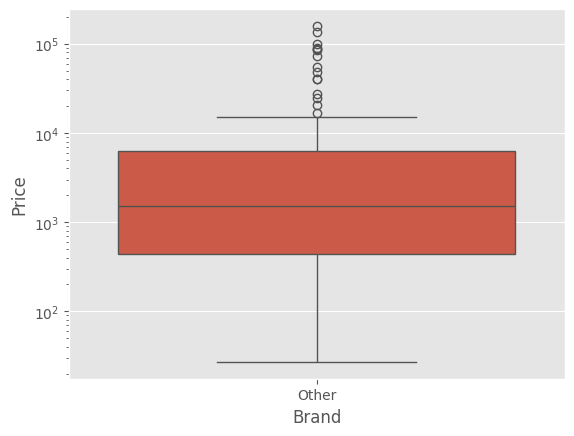

In [25]:
rare_values=list(df['Brand'].value_counts()[df['Brand'].value_counts(normalize=False)<=5].index)
df['Brand']=df['Brand'].apply(lambda x:'Other' if x in rare_values else x)

sns.boxplot(df[df['Brand']=='Other'],x='Brand',y='Price')
#plt.ylim(0,20000)
plt.yscale('log')

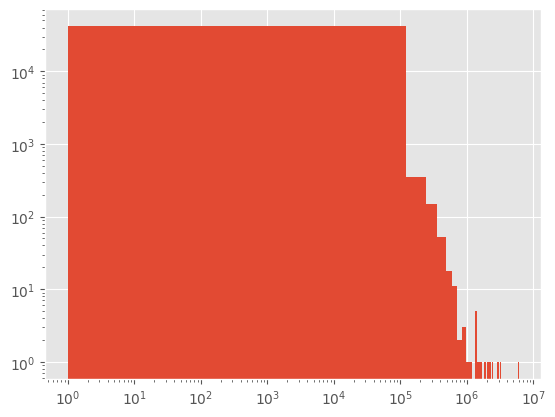

In [26]:
df['Price'].hist(bins=50)
plt.xscale('log')
plt.yscale('log')

df['Price Range']=pd.qcut(df.groupby('Brand')['Price'].transform('median'), q=10)

fig=px.box(df.sort_values('Price Range'),x='Brand',y='Price',color='Price Range')
fig.update_traces(marker_size=1)
fig.update_yaxes(range=[0,5*10**5])
fig.show()

df=df.drop(columns='Price Range')

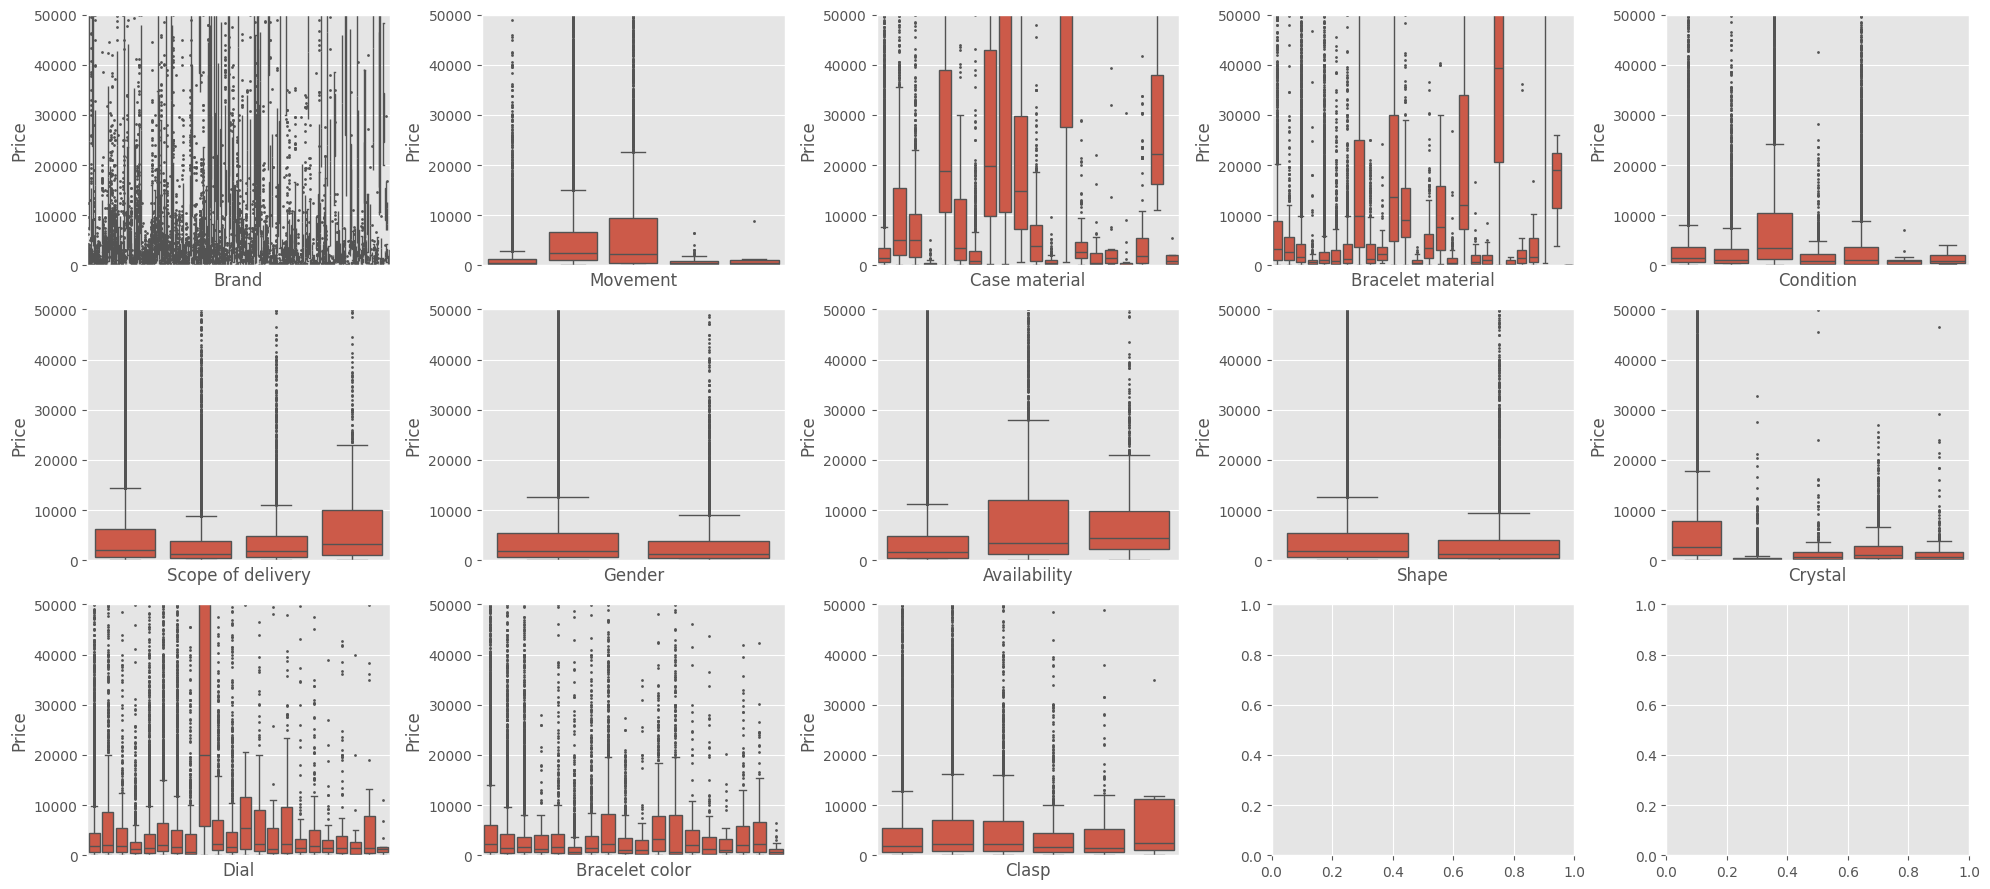

In [27]:
fig,axes=plt.subplots(3,5,figsize=(20,9))
columns=df.select_dtypes(object).columns

for i, col in enumerate(columns):
    ax=axes.flatten()[i]
    sns.boxplot(df,x=col,y='Price',fliersize=1,ax=ax)
    ax.set_ylim(0,50000)
    ax.set_xticks([])
plt.tight_layout()
plt.show()

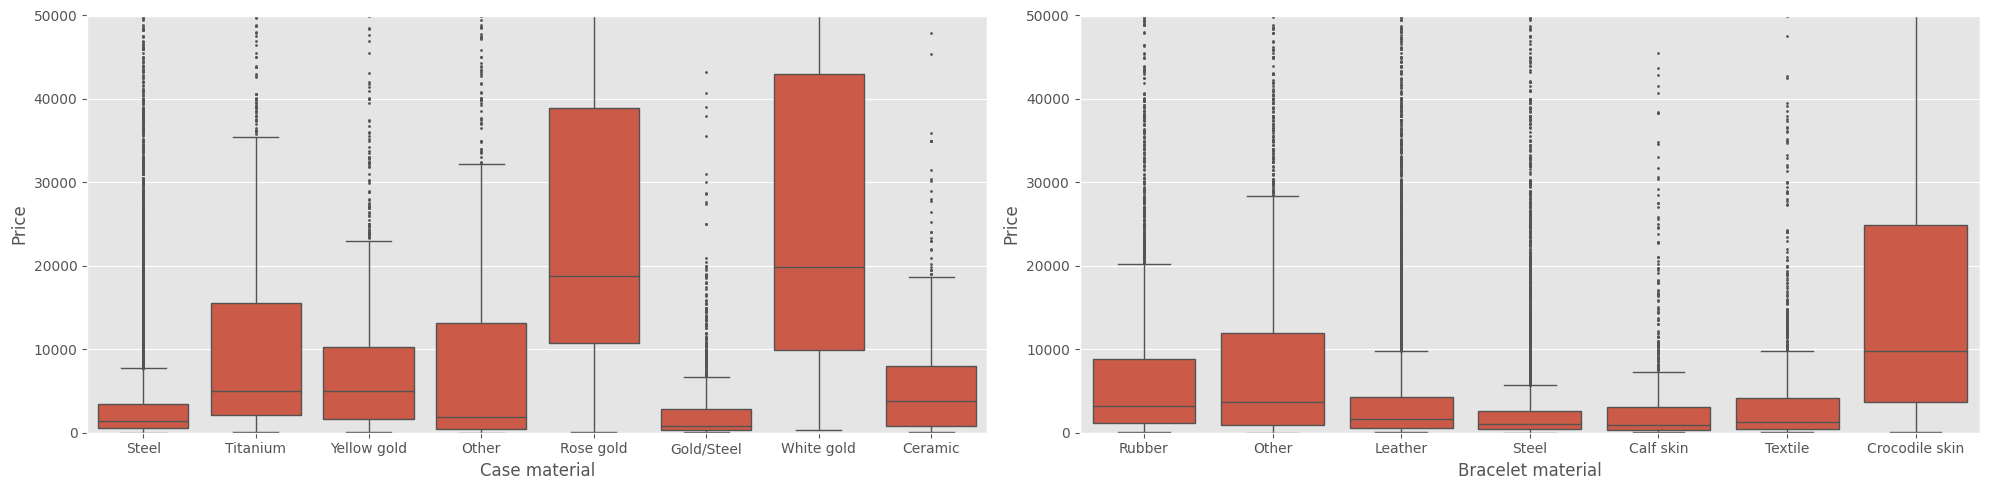

In [28]:
for col in df.filter(like='material').columns:
    rare_values=list(df[col].value_counts()[df[col].value_counts(normalize=True)<=0.02].index)
    df[col]=df[col].apply(lambda x:'Other' if x in rare_values else x)

fig,axes=plt.subplots(1,2,figsize=(20,5))
columns=df.filter(like='material').columns

for i, col in enumerate(columns):
    ax=axes.flatten()[i]
    sns.boxplot(df,x=col,y='Price',fliersize=1,ax=ax)
    ax.set_ylim(0,50000)
    #ax.set_xticks([])
plt.tight_layout()
plt.show()

In [29]:
for col in df.select_dtypes(object):
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

# ML

In [30]:
df=df.dropna(subset='Price')

X=df.drop(columns='Price')
y=df['Price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.1)


In [31]:
from xgboost import XGBRegressor
model=XGBRegressor()

In [32]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [34]:
from sklearn import metrics
r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
mdae_train=metrics.median_absolute_error(train_prediction,y_train)
mdae_test=metrics.median_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'MDAE_train':mdae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'MDAE_test':mdae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9590672354274268, 'MAE_train': 3529.0282828218833, 'MDAE_train': 1230.7611083984375, 'RMSE_train': 11039.054165263715}
{'R2_test': 0.5544819376887956, 'MAE_test': 5004.943297931923, 'MDAE_test': 1213.004867553711, 'RMSE_test': 21449.37259216064}


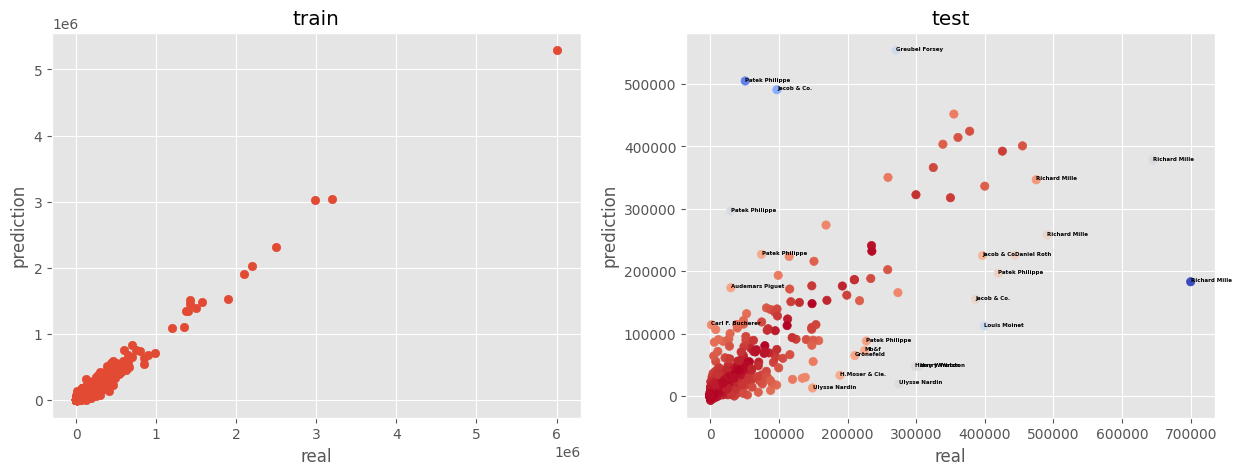

In [35]:
import numpy as np

abs_error=np.abs(y_test-test_prediction)

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')
ax2.scatter(y_test,test_prediction,c=abs_error,cmap='coolwarm_r',alpha=1)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')

brands=X_test[X_test.columns[X_test.columns.str.contains('Brand_')]].idxmax(axis=1).str.replace('Brand_','')
absolute_error=(y_test-test_prediction).abs()
#plot text
for error,actual,prediction,brand in zip(absolute_error,y_test,test_prediction,brands):
    if error<mae_test-5*rmse_test or error>mae_test+5*rmse_test:
        ax2.text(actual,prediction,brand,fontweight='bold',size=4)
    
plt.show()

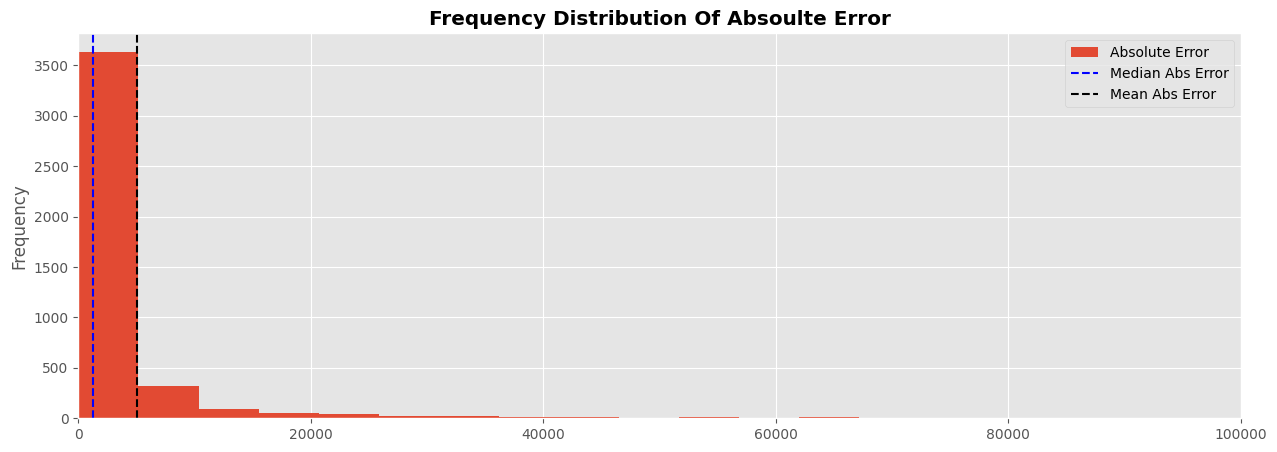

In [36]:
fig,ax=plt.subplots(figsize=(15,5))
absolute_error.plot.hist(ax=ax,bins=100,label='Absolute Error')
ax.set_title('Frequency Distribution Of Absoulte Error',fontweight='bold')
median_abs_error=absolute_error.median()
ax.axvline(median_abs_error,label='Median Abs Error',color='blue',ls='--')
ax.axvline(mae_test,label='Mean Abs Error',color='black',ls='--')
ax.legend()
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.xlim(0,100000)
plt.show()

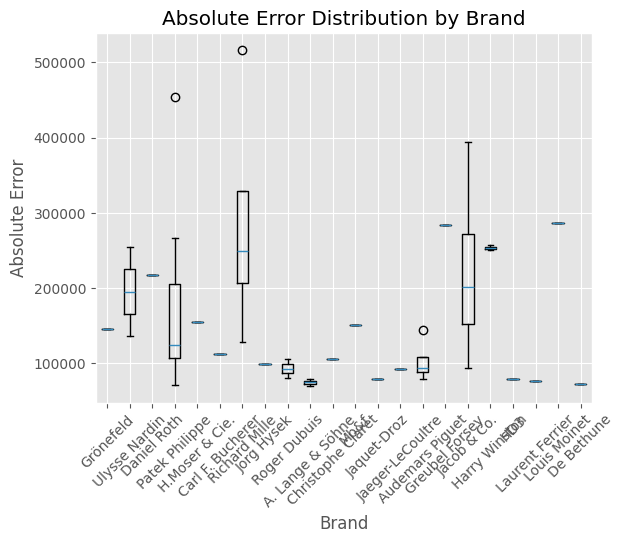

In [37]:
error_df=pd.DataFrame({'Brand':brands,'ABS Error':abs_error})
error_df['Error Level']=error_df['ABS Error'].apply(lambda error:'High' if error<mae_test-3*rmse_test or error>mae_test+3*rmse_test else 'Low')
error_df=error_df[error_df['Error Level']=='High']

data = [error_df[error_df['Brand'] == brand]['ABS Error'].values for brand in error_df['Brand'].unique()]

plt.boxplot(data, labels=error_df['Brand'].unique())
plt.xlabel('Brand')
plt.ylabel('Absolute Error')
plt.title('Absolute Error Distribution by Brand')
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Features'>

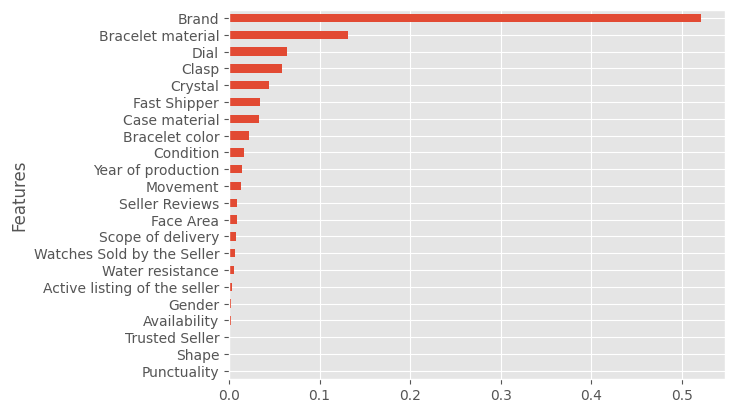

In [38]:
weights=model.feature_importances_
features=X_train.columns

importances_df=pd.DataFrame({'Features':features,'Weights':weights})
importances_df=importances_df.groupby(importances_df['Features'].str.split('_').str[0])['Weights'].sum().sort_values(ascending=True)
importances_df.plot.barh()